In [58]:
import os 
import numpy as np
import mne
import matplotlib.pyplot as plt

In [59]:
subject_id = 1
bdf_file = f'data/raw/S{subject_id:>02d}.bdf'
raw  = mne.io.read_raw_bdf(bdf_file,preload = True)  #读取得到raw的脑电文件

Extracting EDF parameters from d:\all\BCI\codes\bishe\data\raw\S01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1836031  =      0.000 ...  1792.999 secs...


读取数据为raw，并进行结构查看

In [60]:
raw.resample(256, npad='auto') #重设采样率为256

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5104 events found
Event IDs: [ 1  2 11 12 13 14 15]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5104 events found
Event IDs: [ 1  2 11 12 13 14 15]


<RawEDF | S01.bdf, 80 x 459008 (1793.0 s), ~280.2 MB, data loaded>

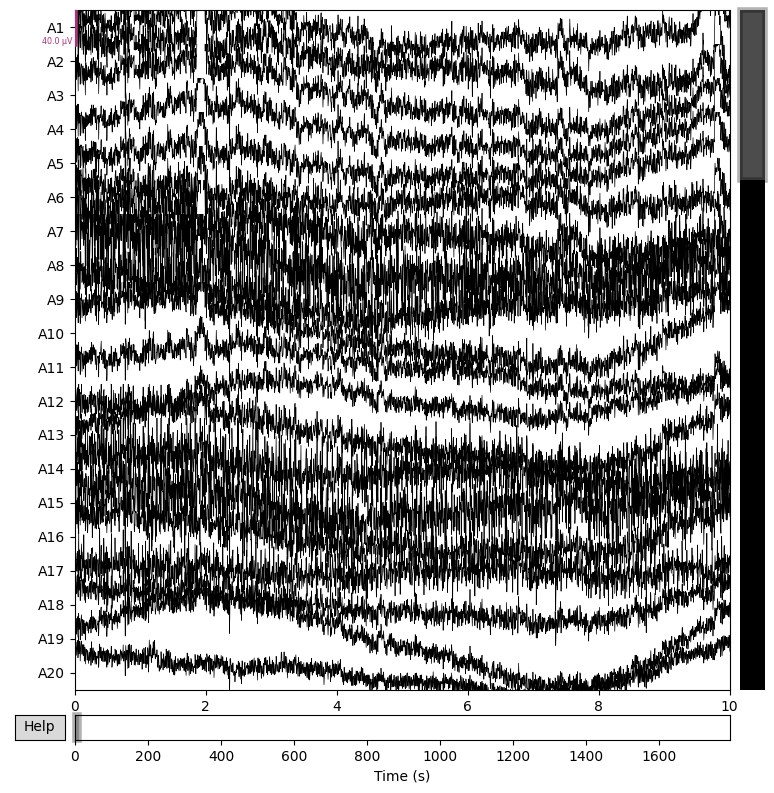

<RawEDF | S01.bdf, 80 x 459008 (1793.0 s), ~280.2 MB, data loaded>


In [61]:
raw.plot(duration = 10)
print(raw)

In [62]:
print(raw.info)
fs = raw.info['sfreq']

<Info | 7 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 79 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2022-06-04 16:23:41 UTC
 nchan: 80
 projs: []
 sfreq: 256.0 Hz
>


转化为events

查找到值增加的sample

In [63]:
events = mne.find_events(raw, initial_event=True, min_duration=4 / 1024)
#这个函数是将stim通道信号转换为事件数组   


#initial_event若第一个sample非0，则创建事件
#min_duration：当作事件 的 事件stim上 的 最短时间 (最小脉冲时间)
#这里采用 4/1024，即为1024采样率的四个点，即为256采样率的一个点
print(events[:5]) 
#数组构成为[位置 0 事件ID]

5105 events found
Event IDs: [    1     2    11    12    13    14    15 65536]
[[    0     0 65536]
 [ 5007     0    11]
 [ 5268     0    13]
 [ 5797     0     1]
 [ 5862     0     1]]


设置滤波器

In [64]:
raw.filter(0.5, 48) 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 1691 samples (6.605 sec)



<RawEDF | S01.bdf, 80 x 459008 (1793.0 s), ~280.2 MB, data loaded>

筛选通道：

实际上有80个通道，我们筛选出来64个

In [65]:
ch_names = raw.info['ch_names']
print(ch_names)
raw.pick_channels(ch_names[0:64]) 

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp', 'Status']


<RawEDF | S01.bdf, 64 x 459008 (1793.0 s), ~224.2 MB, data loaded>

提取出来长度为256的事件原始数据段，epochs

In [66]:
print(events)
target = events[events[:,2]==2] #利用(值==)的方法，将事件ID为2的事件筛选出来
target_data = mne.Epochs(raw,target,tmin=0,tmax = 1,baseline= (0,0),reject_tmax =True).get_data()[:, :, 1:]
#epoch是原始数据的集合
#这里是指，取event的0-1s作为事件数据
#利用get_data()方法提取出来数据为ndarray


[[     0      0  65536]
 [  5007      0     11]
 [  5268      0     13]
 ...
 [452412      0      1]
 [452851      0     14]
 [453400      0     12]]
Not setting metadata
490 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 490 events and 257 original time points ...
0 bad epochs dropped


In [67]:
print(target_data.shape) #这个时候已经是ndarray了，已经可以用shape了
#这里490是样本数 64是通道数 256是采样数

(490, 64, 256)


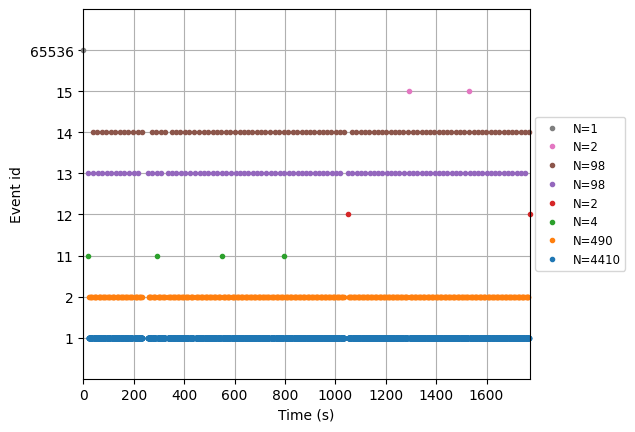

In [68]:
mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp)
plt.show()

提取出来非事件数据段，并将两者的数量进行统计

In [69]:
nontarget = events[events[:, 2] == 1]
nontarget_data = mne.Epochs(
    raw, nontarget, tmin=0, tmax=1, baseline=(0, 0)).get_data()[:, :, 1:]
print(nontarget_data.shape)

Not setting metadata
4410 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4410 events and 257 original time points ...
0 bad epochs dropped
(4410, 64, 256)


In [70]:
target_num = len(target_data)
nontarget_num = len(nontarget_data)


目标样本远小于目标样本，做样本平衡

将非目标样本进行随机抽取

In [71]:
random_nontarget_idx = np.array(range(nontarget_num))
np.random.shuffle(random_nontarget_idx)
sel_nontarget_idx = random_nontarget_idx[:target_num] #利用数组ndarray进行数据抽取
nontarget_data = nontarget_data[sel_nontarget_idx]

开始生成ndarray类型的数据

首先将目标和非目标串联起来 作为X

然后，令标签为 目标为1， 非目标为0


In [72]:
x = np.concatenate([target_data,nontarget_data],axis= 0) 
y = np.zeros(target_num*2)
y[:target_num] +=1
#利用生成随机数的方法，再根据随机idx进行数组打乱
#这种方法的优点在于能够将数据和标签打乱且一一对应
random_idx = np.array(range(target_num*2))
np.random.shuffle(random_idx)
x= x[random_idx]
y =y[random_idx]

创建目录，并且将ndarray类型的数据保存为.npy文件

若要继续访问，利用np.load加载出来即可

In [84]:
root = os.getcwd()
subject_id = 1
npy_dir =root + f'\data\preprocess\S{subject_id:>02d}\\'
os.makedirs(npy_dir,exist_ok=True)
np.save(npy_dir+'x.npy',x)
np.save(npy_dir+'y.npy',y)
